# Sheet 4

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn

## 1 Learning with pytorch

(a)

In [4]:
# TODO: manual check of intermediate gradients with torch.autograd.grad
x1 = torch.tensor(1.5, requires_grad=True)
x2 = torch.tensor(0.5, requires_grad=True)
v1 = x1/x2
v2 = torch.sin(v1)
v3 = torch.exp(x2)
v4 = v1-v3
v5 = v2+v4
L = v4*v5
for val in [x1,x2,v1,v2,v3,v4,v5,L]:
    grad = torch.autograd.grad(L, val, create_graph=True)[0]
    print(f"{val.item():.4f}\t {grad.item():.4f}")


1.5000	 3.0118
0.5000	 -13.7240
3.0000	 1.5059
0.1411	 1.3513
1.6487	 -2.8437
1.3513	 2.8437
1.4924	 1.3513
2.0166	 1.0000


(b)

In [5]:
# TODO: Adam steps
# Adam steps
def get_L(x1, x2):
    return (torch.sin(x1/x2) + x1/x2 - torch.exp(x2)) * (x1/x2 - torch.exp(x2))
    
x1 = torch.tensor(1.5, requires_grad=True)
x2 = torch.tensor(0.5, requires_grad=True)
optimizer = torch.optim.Adam([x1], lr=0.1)
x1s = []
n_epochs = 200
for epoch in range(n_epochs):
    x1s.append(x1.item())
    L = get_L(x1, x2)
    L.backward()
    optimizer.step()
    optimizer.zero_grad()

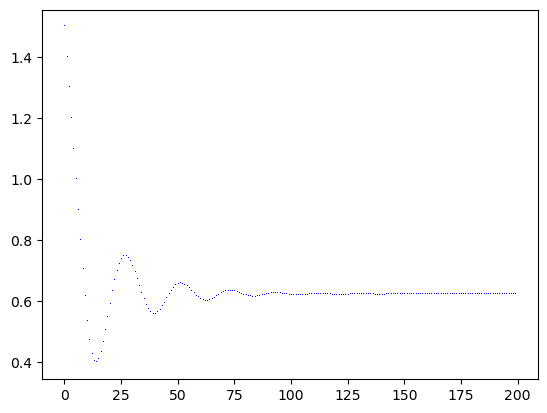

optimal x1 at 0.6207423806190491


In [6]:
# TODO: Plot the loss
its = range(n_epochs)
plt.plot(its, x1s, "b,")
plt.show()
print("optimal x1 at",x1s[-1])

(c)

In [7]:
# TODO: Compute gradients
x1s = np.arange(0,2.01,0.01)
x2 = torch.tensor(0.5, requires_grad=True)
grads = []
for x in x1s:
    x = torch.tensor(x, requires_grad=True)
    L = get_L(x, x2)
    L.backward()
    grads.append(x.grad.item())

grads = np.array(grads)

0.62
agrees up to the precision


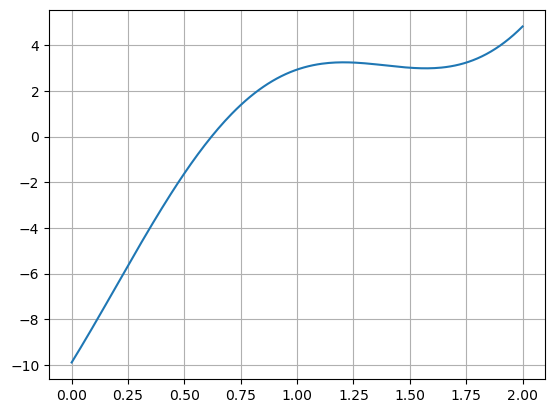

In [8]:
# TODO: Plot gradients and compare to solution for x1 from part (b)
plt.plot(x1s, grads)
plt.grid()
#find the root:
idx = np.argmin(abs(grads))
x0 = x1s[idx]

print(x0)
print("agrees up to the precision")

# 2) Amplitude Regression

In [9]:
# download data to folder data04
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data04"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-2-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data04

100%|██████████| 11/11 [00:00<00:00, 35.15it/s]


 Datentr�ger in Laufwerk C: ist Windows-SSD
 Volumeseriennummer: 22FE-7311

 Verzeichnis von c:\Code\MachineLearningandPhysics\mlph2023-Exercises\data04

14.12.2023  11:13    <DIR>          .
13.12.2023  14:31    <DIR>          ..
13.12.2023  14:31    <DIR>          tutorial-2-data
13.12.2023  14:31        55.093.854 tutorial-2-data (1).zip
13.12.2023  14:38        55.093.854 tutorial-2-data (2).zip
13.12.2023  17:04        55.093.854 tutorial-2-data (3).zip
14.12.2023  11:13        55.093.854 tutorial-2-data (4).zip
13.12.2023  14:31        55.093.854 tutorial-2-data.zip
               5 Datei(en),    275.469.270 Bytes
               3 Verzeichnis(se), 796.105.146.368 Bytes frei


In [10]:
# load data
trn_dat = np.load("data04/tutorial-2-data/trn_dat.npy")
trn_amp = np.load("data04/tutorial-2-data/trn_amp.npy")

val_dat = np.load("data04/tutorial-2-data/val_dat.npy")
val_amp = np.load("data04/tutorial-2-data/val_amp.npy")

tst_dat = np.load("data04/tutorial-2-data/tst_dat.npy")
tst_amp = np.load("data04/tutorial-2-data/tst_amp.npy")

print(f"train data shape: {trn_dat.shape}")
print(f"train amp  shape: {trn_amp.shape}")
print(f"test  data shape: {tst_dat.shape}")
print(f"test  amp  shape: {tst_amp.shape}")
print(f"val   data shape: {val_dat.shape}")
print(f"val   amp  shape: {val_amp.shape}")

train data shape: (30000, 5, 4)
train amp  shape: (30000,)
test  data shape: (30000, 5, 4)
test  amp  shape: (30000,)
val   data shape: (30000, 5, 4)
val   amp  shape: (30000,)


(a)

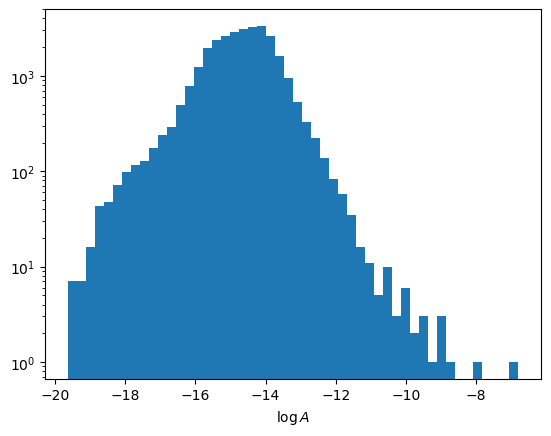

In [11]:
# TODO: Plot amplitudes
plt.yscale("log")
plt.hist(np.log(trn_amp), bins=50)
plt.xlabel(r"$\log A$")
plt.show()

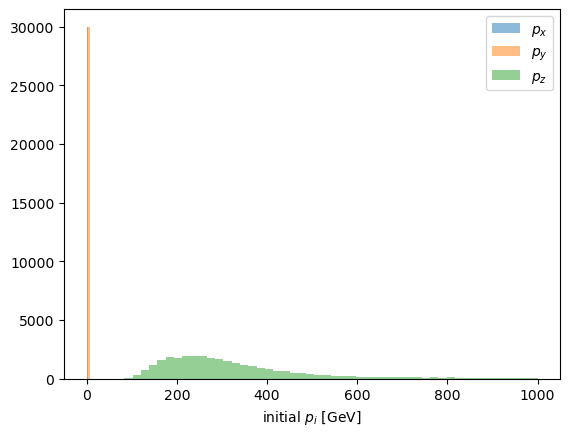

In [12]:
def get_init_pi(ev, i):
    return ev[:,0,i] + ev[:,0,i]

def get_pt(fv):
    return np.sqrt(fv[:, 1]**2 + fv[:, 2]**2)
    


def get_met(fv):
    """ returns MET of the event"""
    return np.sqrt(np.sum(fv[:, :, 1], axis=1)**2
                   +np.sum(fv[:, :, 2], axis=1)**2)

# TODO: Plot incoming momenta
plt.hist(get_init_pi(trn_dat, 1), label=r"$p_x$", alpha=.5, bins=50)
plt.hist(get_init_pi(trn_dat, 2), label=r"$p_y$", alpha=.5, bins=50)
plt.hist(get_init_pi(trn_dat, 3), label=r"$p_z$", alpha=.5, bins=50)
plt.xlabel(r"initial $p_i$ [GeV]")
plt.legend()
plt.show()

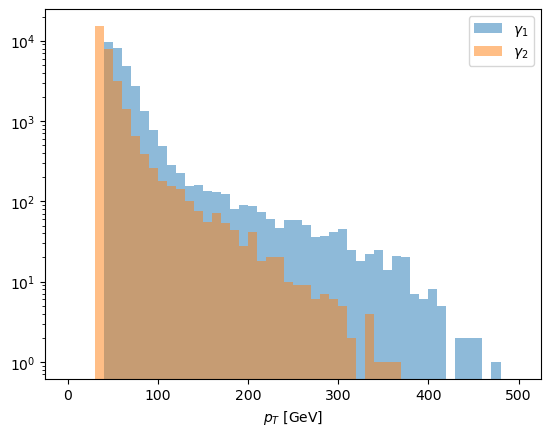

In [13]:
# TODO: Plot photon pTs
plt.yscale("log")
plt.hist(get_pt(trn_dat[:,2]), alpha=.5, range=(0, 500), label=r"$\gamma_1$", bins=50)
plt.hist(get_pt(trn_dat[:,3]), alpha=.5, range=(0, 500), label=r"$\gamma_2$", bins=50)
plt.xlabel(r"$p_T$ [GeV]")
plt.legend()
plt.show()

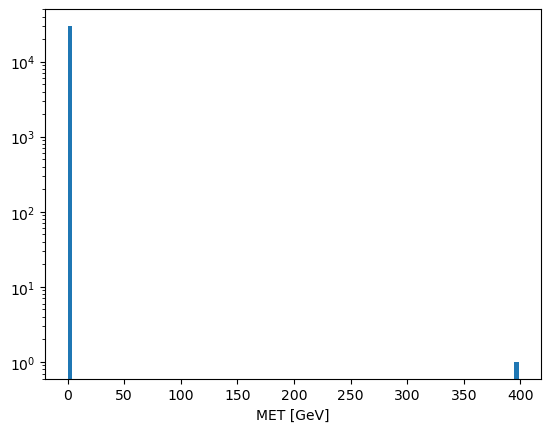

In [14]:
# TODO: Plot MET
plt.yscale("log")
plt.hist(get_met(trn_dat), bins=100)
plt.xlabel(r"MET [GeV]")
plt.show()

(b)

In [15]:
# flatten datasets
nev = trn_dat.shape[0]
trn_datf = np.reshape(trn_dat, (nev, -1))
val_datf = np.reshape(val_dat, (nev, -1))
tst_datf = np.reshape(tst_dat, (nev, -1))

In [16]:
# TODO: Implement preprocessing
def preprocess_x(x_in, mean=None, std=None):
    x = x_in.copy() # do not overwrite
    if mean is None or std is None:
        mean = x.mean(keepdims = True)
        std = x.std(keepdims = True)
    x = (x - mean) / std # standardize
    assert np.isfinite(x).all()
    return torch.tensor(x).float(), mean, std


def preprocess_A(A_in, mean = None, std = None):
    A = A_in.copy()
    A = np.log(A)
    if mean is None or std is None:
        mean = A.mean(keepdims = True)
        std = A.std(keepdims = True)
    A = (A-mean)/std
    assert np.isfinite(A).all() 
    return torch.tensor(A).float().unsqueeze(-1), mean, std
    

def undo_preprocess_A(A_in, mean, std):
    A = A_in.copy()
    A = A * std +mean
    A = np.exp(A)
    return A

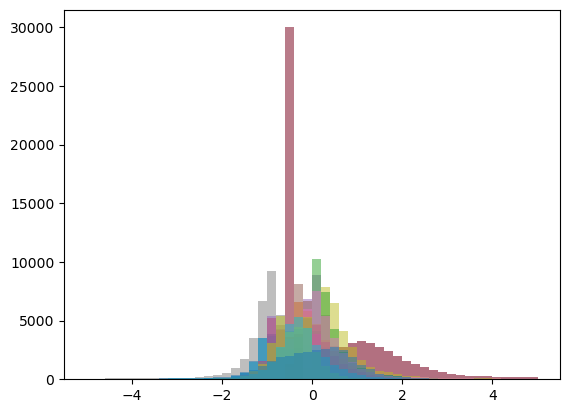

In [17]:
# check that network inputs are O(1)
for i in range(20):
    plt.hist(preprocess_x(trn_datf)[0][:,i], range=(-5,5), alpha=.5, bins=50)
plt.hist(preprocess_A(trn_amp)[0][:,0], range=(-5,5), alpha=.5, bins=50)
plt.show()

In [18]:
# TODO: Implement dataset class
class amp_dataset(torch.utils.data.Dataset):
    
    def __init__(self, data, amp):
        self.data = data
        self.amp = amp

    def __len__(self):
        return len(self.amp)

    def __getitem__(self, idx):
        return self.data[idx], self.amp[idx]
    

In [61]:
# TODO: create datasets and dataloaders
from torch.utils.data import DataLoader
trn_datfp, mean_x, std_x = preprocess_x(trn_datf)
val_datfp, _, _ = preprocess_x(val_datf, mean_x, std_x)
tst_datfp, _, _ = preprocess_x(tst_datf, mean_x, std_x)

trn_ampp, mean_A, std_A = preprocess_A(trn_amp)
val_ampp, _, _ = preprocess_A(val_amp, mean_A, std_A)
tst_ampp, _, _ = preprocess_A(tst_amp, mean_A, std_A)

trn_dataset = amp_dataset(trn_datfp, trn_ampp)
val_dataset = amp_dataset(val_datfp, val_ampp)
tst_dataset = amp_dataset(tst_datfp, tst_ampp)

trn_dataloader = DataLoader(trn_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
tst_dataloader = DataLoader(tst_dataset, batch_size=64, shuffle=True)

(c)

In [20]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


In [58]:
# TODO: Implement network
class amp_net(nn.Module):
    
    def __init__(self, ipt_dim=20, opt_dim=1, hdn_dim=32, n_layers=2):
        super(amp_net, self).__init__()

        assert n_layers>=2
        layers  =[]
        layers.append(nn.Linear(ipt_dim, hdn_dim))
        layers.append(nn.ReLU())
        for i in range(n_layers-1):
            layers.append(nn.Linear(hdn_dim, hdn_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hdn_dim, opt_dim))
        self.linear_relu_stack = nn.Sequential(*layers)

    def forward(self, x):
        out = self.linear_relu_stack(x)
        return out

In [59]:
# TODO: create network
model = []
model = amp_net()
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")

amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Model has 1761 trainable parameters


In [62]:
# take first batch from train loader
x, A = next(iter(trn_dataloader))
print(x.shape, A.shape)

torch.Size([64, 20]) torch.Size([64, 1])


In [63]:
# TODO: Train network on first batch for 10000 iterations
niterations = 10000
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []

model.train()
for it in range(niterations):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, A)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    if it%1000==0:
        print(f"{it} / {niterations}")


0 / 10000
1000 / 10000
2000 / 10000
3000 / 10000
4000 / 10000
5000 / 10000
6000 / 10000
7000 / 10000
8000 / 10000
9000 / 10000


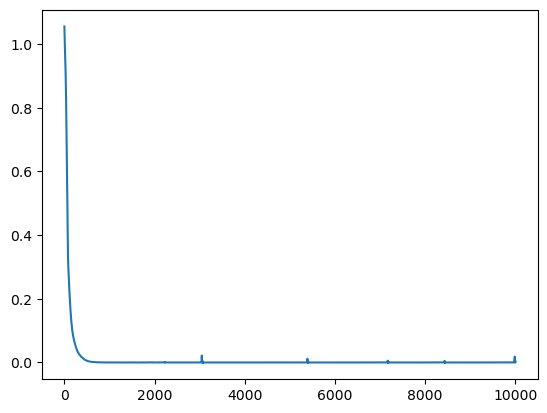

In [64]:
# TODO: Plot loss
plt.plot(range(niterations),losses)

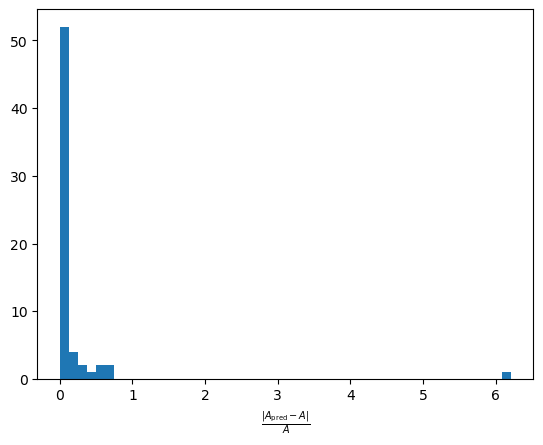

In [52]:
# TODO: Plot (A_predicted - A_true) / A_true
pred = model(x)
diff = torch.abs((pred.detach() - A) / A).cpu().numpy()

plt.hist(diff, bins=50)
plt.xlabel(r"$\frac{|A_\mathrm{pred}-A|}{A}$")
plt.show()

(d)

In [27]:
# TODO: Train network on the full training dataset
def batch_loss(model, x, y):
    x, y = x.to(device), y.to(device)
    pred = model(x)
    loss = loss_fn(pred, y)
    return loss

def train_epoch(model, dataloader, losses, batch_loss_fn):
    #iterator = iter(dataloader)
    #for i in range(len(dataloader)):
    for x, y in dataloader:
        #x, y = next(iterator)
        optimizer.zero_grad()
        
        loss = batch_loss_fn(model, x, y)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def val_epoch(model, dataloader, losses, batch_loss_fn):
    losses_epoch = []
    with torch.no_grad():
        for x, y in dataloader:
            loss = batch_loss_fn(model, x,y)
            losses_epoch.append(loss.item())
    losses.append(np.mean(losses_epoch))
    return losses

In [65]:
model = amp_net()
print(model)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters:d} trainable parameters")
niterations = 10000
loss_fn = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []
n_epochs =100

for epoch in range(n_epochs):
    train_losses = train_epoch(model, trn_dataloader, train_losses, batch_loss)
    
    val_losses = val_epoch(model, val_dataloader, val_losses, batch_loss)
    
    if epoch%10==0:
        print(f"{epoch} / {n_epochs}")



amp_net(
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=20, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
  )
)
Model has 1761 trainable parameters
0 / 100
10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100


In [66]:
def evaluate():
    # plot loss
    plt.yscale("log")
    plt.plot(np.arange(len(train_losses)) / len(trn_dataloader), train_losses)
    plt.plot(np.arange(len(val_losses)), val_losses)
    plt.show()
    
    # calculate predictions
    predsp = np.array([])
    model.eval()
    with torch.no_grad():
        for x, y in tst_dataloader:
            pred = model(x)
            predsp = np.append(predsp, pred)

    # undo preprocessing
    preds = undo_preprocess_A(predsp, mean_A, std_A) 
    
    #plt.yscale("log")
    plt.hist(np.log(preds), alpha=.5, range=(-20, -8), bins=50)
    plt.hist(np.log(tst_amp), alpha=.5, range=(-20, -8), bins=50)
    plt.xlabel(r"$\log A$")
    plt.show()

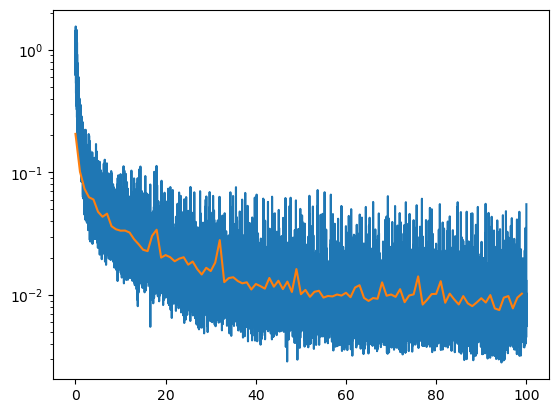

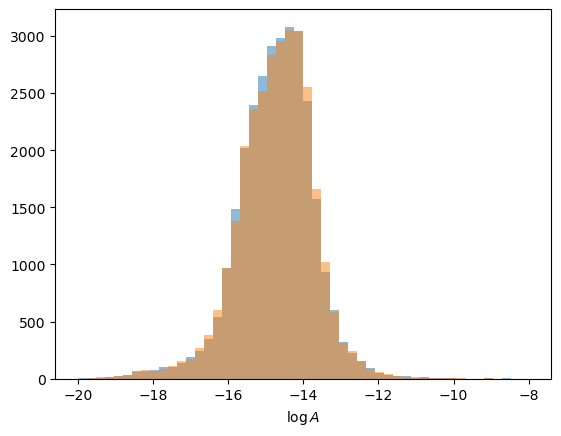

In [67]:
evaluate()

In [ ]:
# TODO: Plot loss and amplitude histogram

(e)

In [ ]:
# TODO: create dataloaders with reduced dataset

batch_size = 64
trn_dataloader_reduced = ...
val_dataloader_reduced = ...
tst_dataloader_reduced = ...

In [ ]:
# TODO: Train model on reduced dataset

In [ ]:
# TODO: Evaluate model

In [ ]:
# TODO: Implement your regularization approach, train a model and evaluate it